<a href="https://colab.research.google.com/github/Nardeen-99/NAB-Corpus/blob/main/NAB_preprocessing_k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NAB Corpus

##### The NAB corpus of 58 timeseries data files is designed to provide data for research in streaming anomaly detection. It is comprised of both real-world and artifical timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics. All data files contain anomalies, unless otherwise noted.
https://www.kaggle.com/datasets/boltzmannbrain/nab

##### The majority of the data is real-world from a variety of sources such as AWS server metrics, Twitter volume, advertisement clicking metrics, traffic data, and more. All data is included in the repository, with more details in the data readme

##### realKnownCause:

This is data for which we know the anomaly causes; no hand labeling.

ambient_temperature_system_failure.csv: The ambient temperature in an office
setting.

In [115]:
!git clone https://github.com/Nardeen-99/NAB-Corpus.git

fatal: destination path 'NAB-Corpus' already exists and is not an empty directory.


In [116]:
!pip install pyod

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
from pyod.models.mad import MAD
from sklearn.model_selection import train_test_split
import warnings
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose

In [118]:
raw_df = pd.read_csv("/content/NAB-Corpus/ambient_temperature_system_failure.csv")
raw_df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [119]:
df = raw_df.copy()
df

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
...,...,...
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226


 Each row represents the aggregation value within a 60-minutes interval

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [121]:
print(df.nunique())
print(df.isnull().sum())

timestamp    7267
value        7267
dtype: int64
timestamp    0
value        0
dtype: int64


##### EDA and Data Analysis

In [122]:
# change the timestamp attribute data type
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df.dtypes)

timestamp    datetime64[ns]
value               float64
dtype: object


In [123]:
shows_added = df.groupby('timestamp')[['value']].count()
shows_added

,value
timestamp,
2013-07-04 00:00:00,1
2013-07-04 01:00:00,1
2013-07-04 02:00:00,1
2013-07-04 03:00:00,1
2013-07-04 04:00:00,1
...,...
2014-05-28 11:00:00,1
2014-05-28 12:00:00,1
2014-05-28 13:00:00,1


In [124]:
df = df.set_index('timestamp')
df.head()

,value
timestamp,
2013-07-04 00:00:00,69.880835
2013-07-04 01:00:00,71.220227
2013-07-04 02:00:00,70.877805
2013-07-04 03:00:00,68.959400
2013-07-04 04:00:00,69.283551


In [125]:
# Define a function to convert Fahrenheit to Celsius
def fahrenheit_to_celsius (i):
  return (i - 32) * 5/9

df['value'] = df['value'].apply(fahrenheit_to_celsius)

To convert a temperature from Fahrenheit to Celsius, you can use the following formula:

C=
9/5
​*
 (F−32)

In [126]:
df.head()

,value
timestamp,
2013-07-04 00:00:00,21.044908
2013-07-04 01:00:00,21.789015
2013-07-04 02:00:00,21.598781
2013-07-04 03:00:00,20.533000
2013-07-04 04:00:00,20.713084


In [127]:
#The day of the week with Monday=0, Sunday=6.
df['day_of_week'] = df.index.day_name()
df

,value,day_of_week
timestamp,,
2013-07-04 00:00:00,21.044908,Thursday
2013-07-04 01:00:00,21.789015,Thursday
2013-07-04 02:00:00,21.598781,Thursday
2013-07-04 03:00:00,20.533000,Thursday
2013-07-04 04:00:00,20.713084,Thursday
...,...,...
2014-05-28 11:00:00,22.427892,Wednesday
2014-05-28 12:00:00,22.318309,Wednesday
2014-05-28 13:00:00,22.248092,Wednesday


In [128]:
shows_added = df.groupby('day_of_week')[['value']].mean()
shows_added

,value
day_of_week,
Friday,22.359931
Monday,21.420612
Saturday,21.490596
Sunday,20.631669
Thursday,22.364722
Tuesday,21.994768
Wednesday,22.247172


In [129]:
df['is_month_end'] = df.index.is_month_end
df

,value,day_of_week,is_month_end
timestamp,,,
2013-07-04 00:00:00,21.044908,Thursday,False
2013-07-04 01:00:00,21.789015,Thursday,False
2013-07-04 02:00:00,21.598781,Thursday,False
2013-07-04 03:00:00,20.533000,Thursday,False
2013-07-04 04:00:00,20.713084,Thursday,False
...,...,...,...
2014-05-28 11:00:00,22.427892,Wednesday,False
2014-05-28 12:00:00,22.318309,Wednesday,False
2014-05-28 13:00:00,22.248092,Wednesday,False


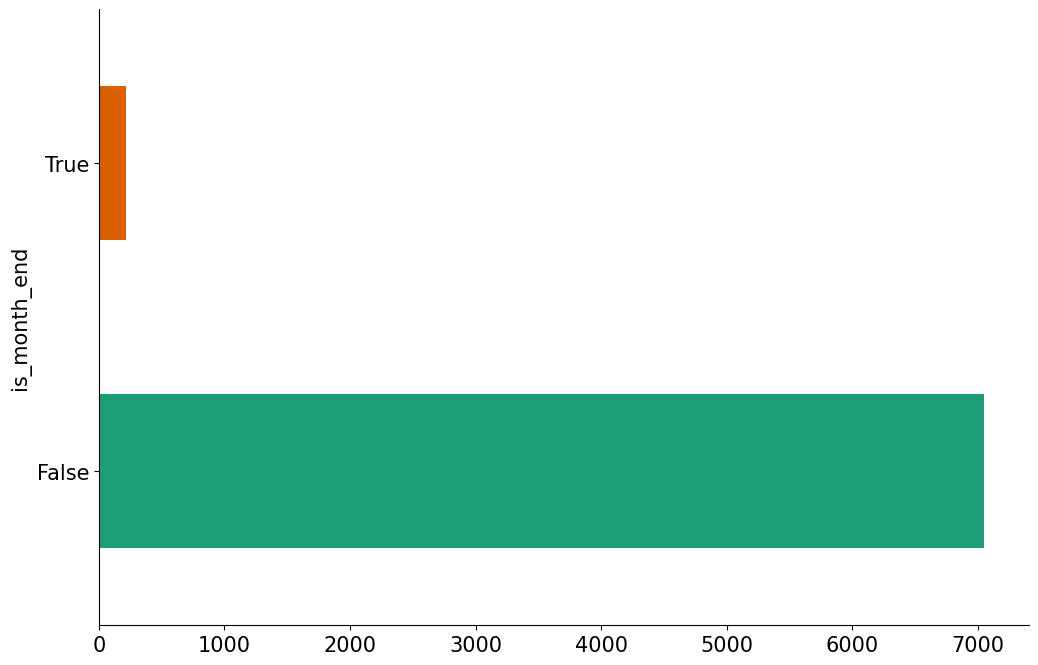

In [130]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('is_month_end').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

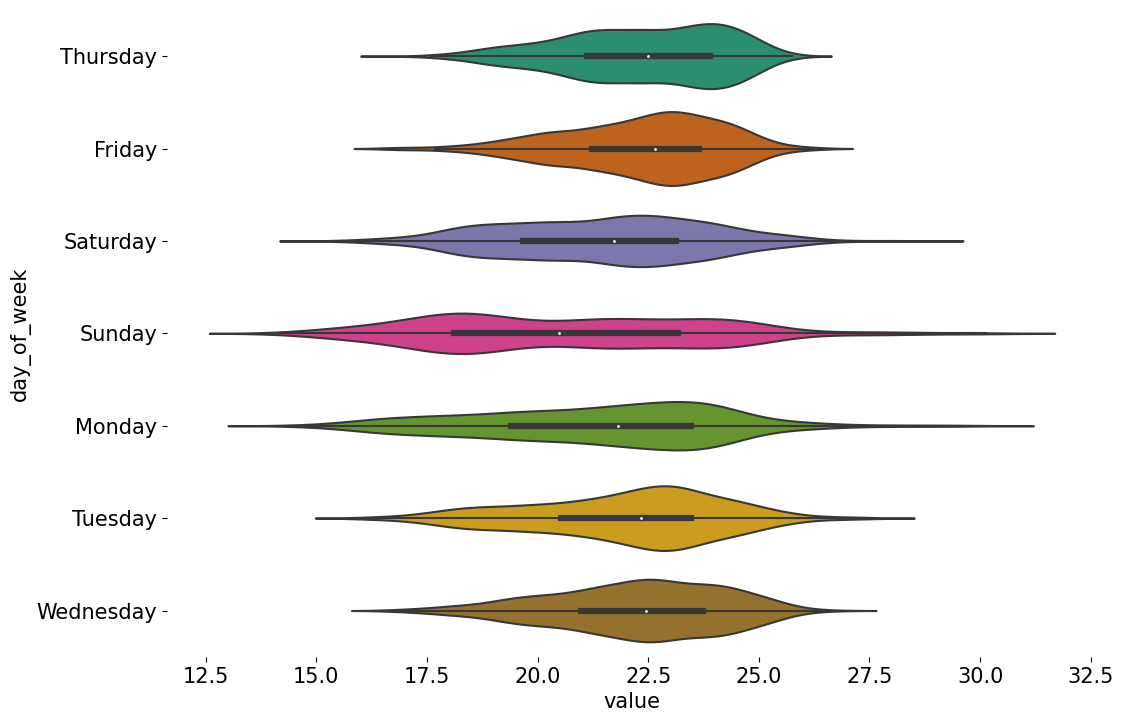

In [131]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['day_of_week'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='value', y='day_of_week', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [132]:
df['quarter_hear'] = df.index.quarter
df.quarter_hear.astype(int)

timestamp
2013-07-04 00:00:00    3
2013-07-04 01:00:00    3
2013-07-04 02:00:00    3
2013-07-04 03:00:00    3
2013-07-04 04:00:00    3
                      ..
2014-05-28 11:00:00    2
2014-05-28 12:00:00    2
2014-05-28 13:00:00    2
2014-05-28 14:00:00    2
2014-05-28 15:00:00    2
Name: quarter_hear, Length: 7267, dtype: int64

In [133]:
value_of_quarter_year = df.groupby('quarter_hear')['value'].mean()
value_of_quarter_year

quarter_hear
1    21.796311
2    19.062007
3    21.142757
4    23.928988
Name: value, dtype: float64

<Axes: xlabel='quarter_hear'>

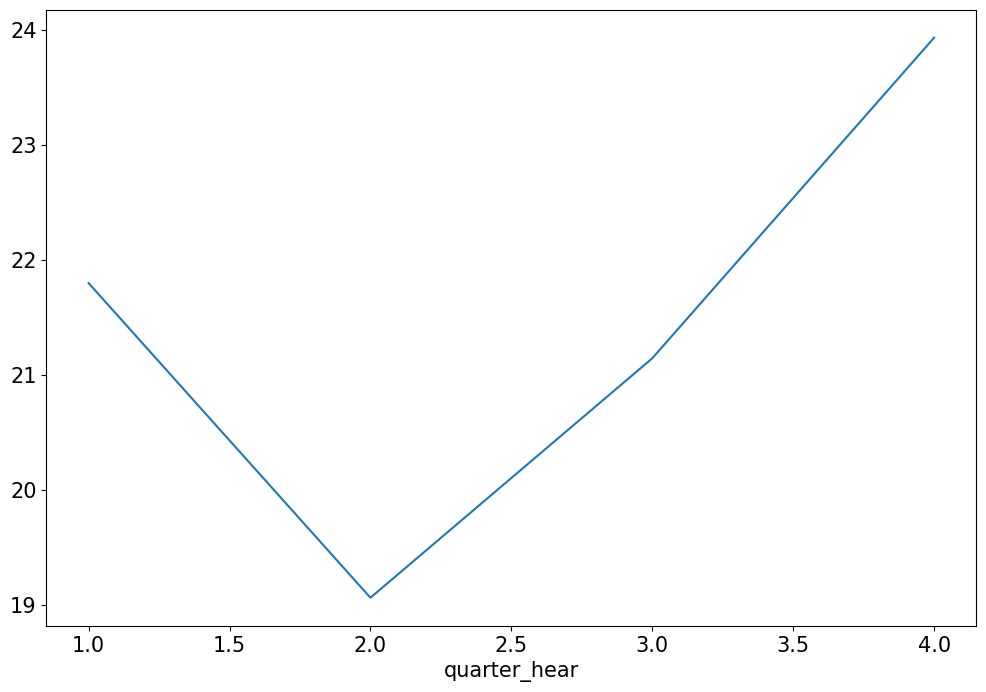

In [134]:
value_of_quarter_year.plot()

The temperature  is usually decreasing in the the second quarter if the year

<Axes: xlabel='timestamp'>

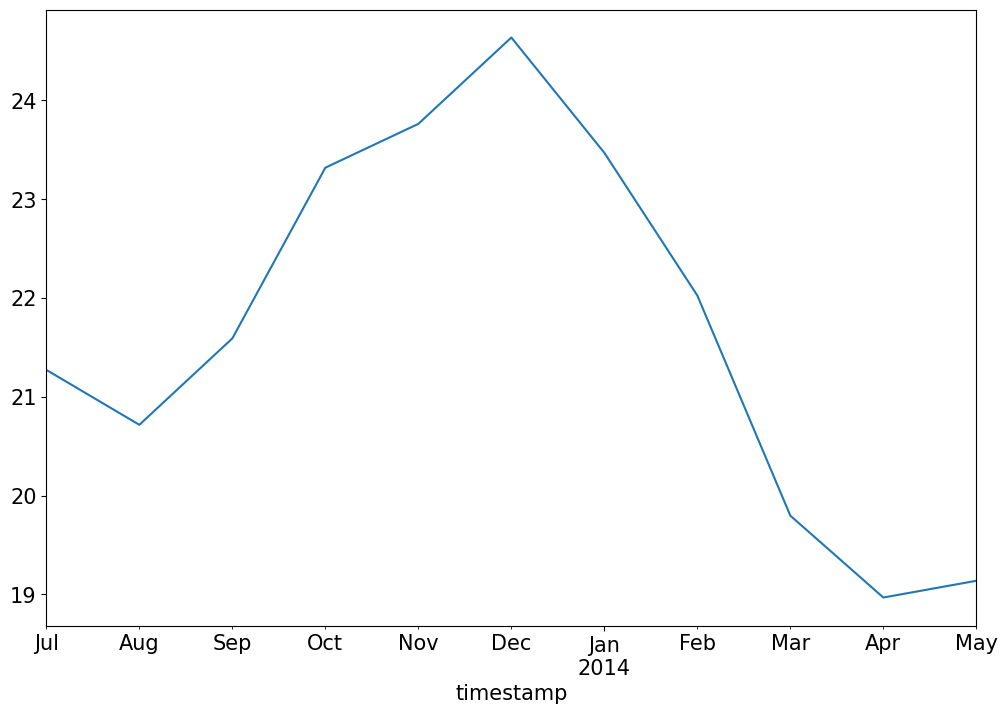

In [135]:
weekly_value = df['value'].resample('1M').mean()   # For each week.mean()
weekly_value.plot()

an obvious decrease in the time between Dec 2013 till Mar 2014

In [136]:
weekly_value

timestamp
2013-07-31    21.272141
2013-08-31    20.716548
2013-09-30    21.591005
2013-10-31    23.317884
2013-11-30    23.761377
2013-12-31    24.634945
2014-01-31    23.468552
2014-02-28    22.024219
2014-03-31    19.797310
2014-04-30    18.969130
2014-05-31    19.138518
Freq: M, Name: value, dtype: float64

In [137]:
df.head()

,value,day_of_week,is_month_end,quarter_hear
timestamp,,,,
2013-07-04 00:00:00,21.044908,Thursday,False,3
2013-07-04 01:00:00,21.789015,Thursday,False,3
2013-07-04 02:00:00,21.598781,Thursday,False,3
2013-07-04 03:00:00,20.533000,Thursday,False,3
2013-07-04 04:00:00,20.713084,Thursday,False,3


<Axes: >

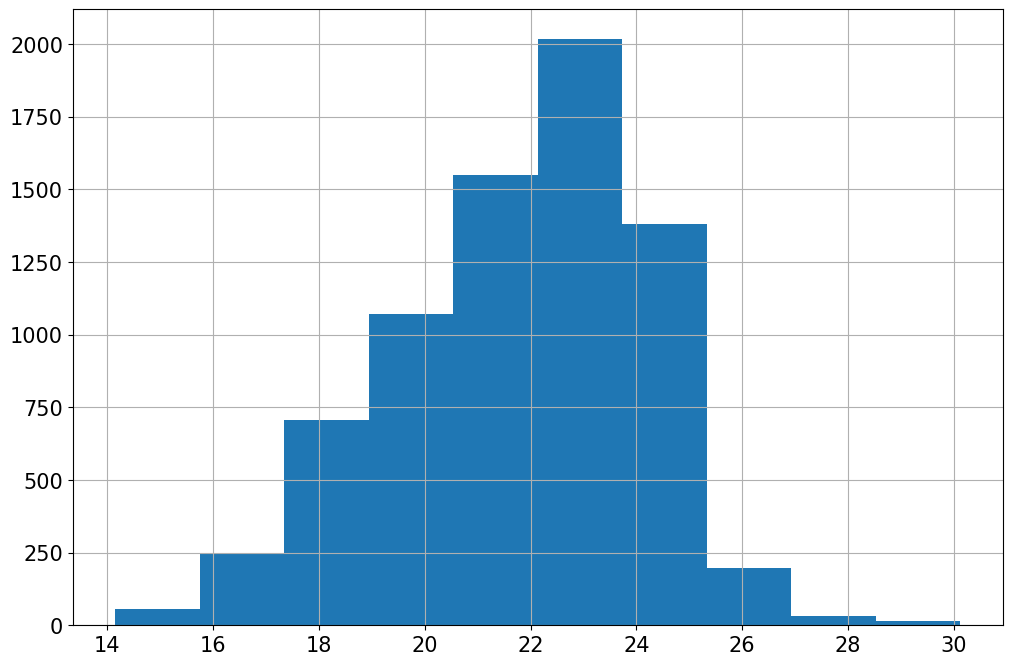

In [138]:
df['value'].hist()

The dataset tends to be Normally distributed

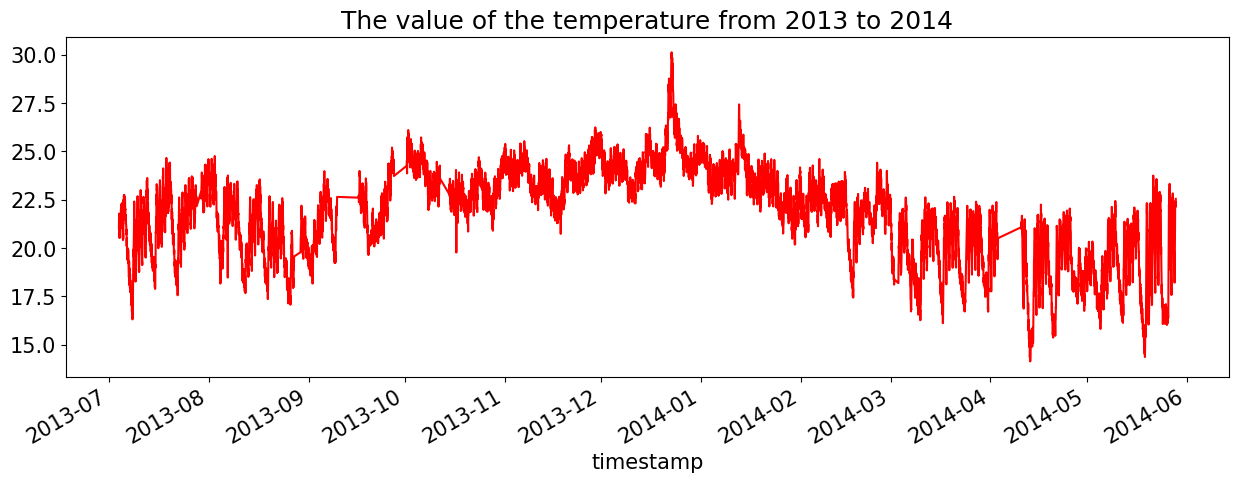

In [139]:
df['value'].plot(color = 'red', figsize = (15, 5))
plt.title('The value of the temperature from 2013 to 2014')
plt.show()

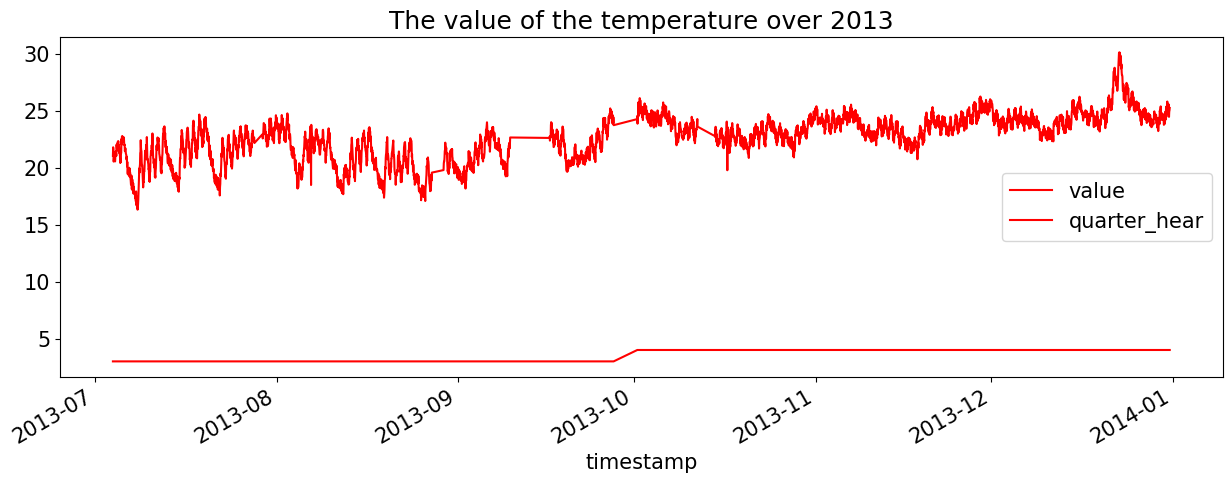

In [140]:
# Select from the date 2013-07-04 00:00:00 to 2013-12-31 11:59:00, so that we can make a close look to the change of the value
df['2013-07-04 00:00:00' : '2013-12-31 11:59:00'].plot(color = 'red', figsize = (15, 5))
plt.title('The value of the temperature over 2013')
plt.show()

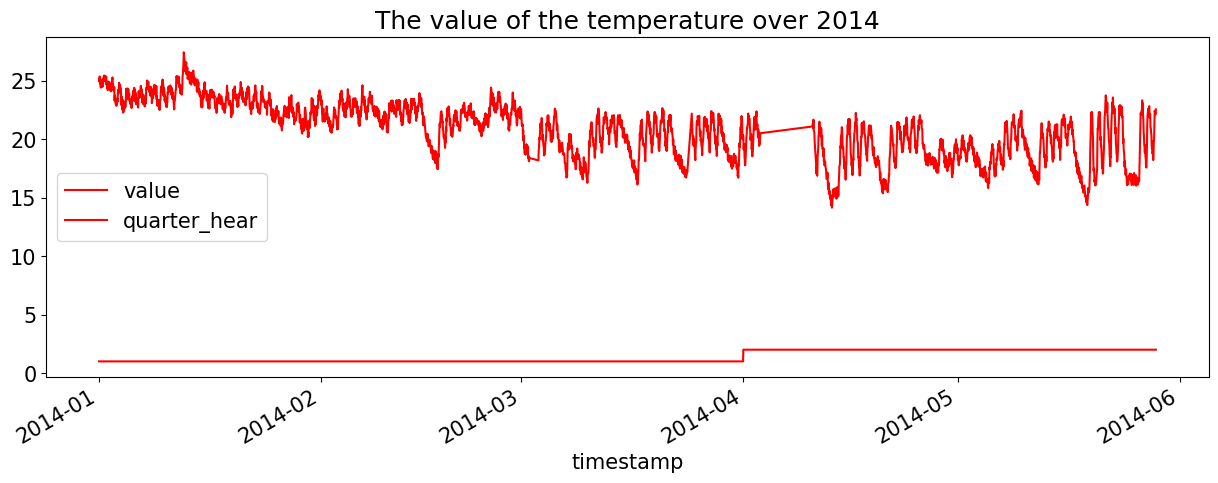

In [141]:
# Select from the date 2014-01-01 00:00:00 to 2014-05-28 15:00:00, so that we can make a close look to the change of the value
df['2014-01-01 00:00:00' : '2014-05-28 15:00:00'].plot(color = 'red', figsize = (15, 5))
plt.title('The value of the temperature over 2014')
plt.show()

In [142]:
import plotly.graph_objects as go
fig = go.Figure([go.Scatter(x = df.index, y = df['value'])])
fig.show()

Here we can notice that the overall temperature  started decreasing starting from almost (Jan 12, 2014, 21:00) -The last peak- the temperature  was (80.9) and decreased overtime

In [143]:
df = df[['value']]
df

,value
timestamp,
2013-07-04 00:00:00,21.044908
2013-07-04 01:00:00,21.789015
2013-07-04 02:00:00,21.598781
2013-07-04 03:00:00,20.533000
2013-07-04 04:00:00,20.713084
...,...
2014-05-28 11:00:00,22.427892
2014-05-28 12:00:00,22.318309
2014-05-28 13:00:00,22.248092


In [144]:
print(df.index.freq)

None


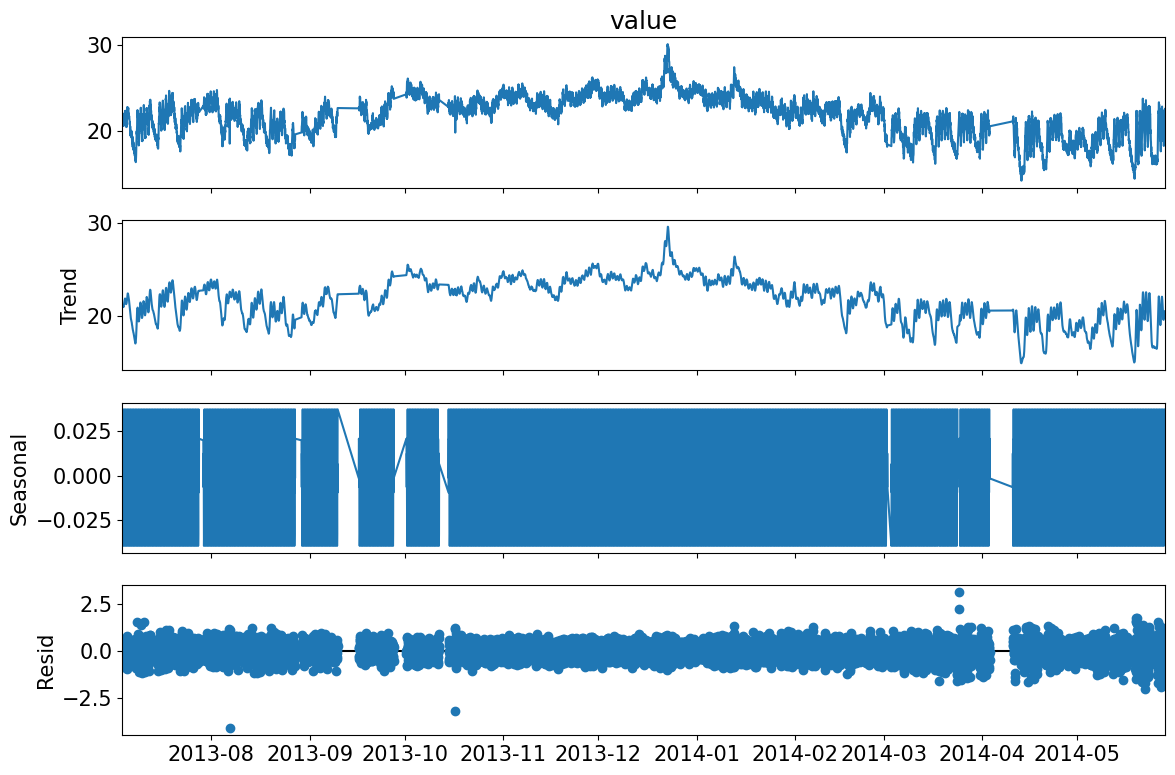

In [145]:
#applying STL decompose to divide the time series into smaller components
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=15)
result = seasonal_decompose(df['value'], model="additive", period=12)
fig = result.plot()

Identifying trends: the overall temperature decreasing over time

Detect anomalies: residuals reveal spikes or outliers

#### Checking Stationarity

In [146]:
#split the time series into two contiguous sequences. We can then calculate the mean and variance of each group of numbers and compare the values
X = df.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=22.413543, mean2=21.188992
variance1=3.437125, variance2=6.948690


they have almost the same mean but different variance values

#####Augmented Dickey-Fuller test


In [147]:
# apply augmented dickey fuller test to make sure that if the data is stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.517563
p-value: 0.000002
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [148]:
df.head()

,value
timestamp,
2013-07-04 00:00:00,21.044908
2013-07-04 01:00:00,21.789015
2013-07-04 02:00:00,21.598781
2013-07-04 03:00:00,20.533000
2013-07-04 04:00:00,20.713084


H0 (Null Hypohesis): the data is non stationary

H1 (Alternative Hypothesis): the data is stationary

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -5 is less than the value of -3.431 at 2%.

This suggests that we can reject the null hypothesis with a significance level of less than 2% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

In [149]:
df.to_csv('NAB_preprocessed.unknown', index=True)

In [150]:
df = pd.read_csv("/content/NAB_preprocessed.unknown")

In [151]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,21.044908
1,2013-07-04 01:00:00,21.789015
2,2013-07-04 02:00:00,21.598781
3,2013-07-04 03:00:00,20.533000
4,2013-07-04 04:00:00,20.713084
